# End to End Matching Example

Please run [Record-Linkage-Example.ipynb](Record-Linkage-Example.ipynb) before this one in order to get the trained model at `../trained-models/notebooks/rl/rl-model.ckpt`.

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Loading Test Data

In [6]:
import json
from ordered_set import OrderedSet

def load_pair_set(filepath):
    with open(filepath, 'r') as f:
        test_pos_pair_set = json.load(f)
        return OrderedSet(tuple(pair) for pair in test_pos_pair_set)

train_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-train-pos-pairs.json')
valid_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-valid-pos-pairs.json')
test_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-test-pos-pairs.json')

In [7]:
import json

def load_record_dict(filepath):
    with open(filepath, 'r') as f:
        record_dict = json.load(f)
        return {int(id_): record for id_, record in record_dict.items()}

train_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-train-records.json')
valid_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-valid-records.json')
test_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-test-records.json')

## Loading Model

In [8]:
from entity_embed import LinkageEmbed

model = LinkageEmbed.load_from_checkpoint('../trained-models/notebooks/rl/rl-model.ckpt')

## Blocking

In [9]:
%%time

eval_batch_size = 64
ann_k = 100
sim_threshold = 0.3

train_found_pair_set, train_vector_dict = model.predict_pairs(
    record_dict=train_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_vector_dict=True
)

# batch embedding:   0%|          | 0/44 [00:00<?, ?it/s]

CPU times: user 1min 39s, sys: 2.28 s, total: 1min 41s
Wall time: 17.8 s


In [10]:
%%time

valid_found_pair_set, valid_vector_dict = model.predict_pairs(
    record_dict=valid_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_vector_dict=True
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 33.5 s, sys: 777 ms, total: 34.2 s
Wall time: 6.25 s


In [11]:
%%time

test_found_pair_set, test_vector_dict = model.predict_pairs(
    record_dict=test_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_vector_dict=True
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 26.8 s, sys: 790 ms, total: 27.6 s
Wall time: 5.1 s


In [12]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(test_found_pair_set), len(test_record_dict))

3.144273127753304

In [13]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(test_found_pair_set, test_pos_pair_set)

(0.087215411558669, 0.996)

## Matching: Compare

Make a dataframe `df` with all records (train, valid, test) to add additional features:

In [14]:
record_dict = {**train_record_dict, **valid_record_dict, **test_record_dict}

In [15]:
import pandas as pd

df = pd.DataFrame.from_dict(record_dict, orient='index')
df = df.drop(columns='id')

In [16]:
df['all'] = df.agg('{0[name]} - {0[description]} - {0[manufacturer]} - {0[price]}'.format, axis=1)
df['price'] = pd.to_numeric(df['price'].str.replace(' ', ''), errors='coerce')
df.head(3)

,name,description,manufacturer,price,__source,cluster,all
1728,filemaker pro 8 . 5 5 - user pack,system requirements macintosh macintosh comput...,,1149.00,google,1561,filemaker pro 8 . 5 5 - user pack - system req...
255,diskeeper 2007 pro premier 5 - lic pack,- marketing information : diskeeper pro premie...,diskeeper corporation,736.66,amazon,1207,diskeeper 2007 pro premier 5 - lic pack - - ma...
2889,emc securid appl mnt - ent / std 17mo per u 2k...,,,16.00,google,2231,emc securid appl mnt - ent / std 17mo per u 2k...


Replace all `record_dict`s (train, valid, test) to add additional features:

In [17]:
train_record_dict = df.loc[train_record_dict.keys()].to_dict(orient='index')
valid_record_dict = df.loc[valid_record_dict.keys()].to_dict(orient='index')
test_record_dict = df.loc[test_record_dict.keys()].to_dict(orient='index')

del df

In [18]:
import textdistance as td
import math

def token_ops(func):
    def new_func(x, y):
        return func(x.split(), y.split())    
    return new_func

def empty_str(x, y):
    return int(not x or not y)

def empty_num(x, y):
    return int(not x or not y or math.isnan(x) or math.isnan(y))

def zero_if_empty(x):
    if not x or math.isnan(x):
        return 0
    else:
        return x

def abs_diff(x, y):
    return abs(zero_if_empty(x) - zero_if_empty(y))

def abs_diff_log10(x, y, min_val=math.log10(1e-5)):
    diff = abs_diff(x, y)
    if diff > 0:
        return max(math.log10(diff), min_val)
    else:
        return min_val

SIM_FUNC_DICT = {
    ("all", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("all", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("all", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("all", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("description", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("description", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("description", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("description", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("manufacturer", "empty_str"): empty_str,
    ("manufacturer", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("manufacturer", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("manufacturer", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("manufacturer", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("name", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("name", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("name", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("name", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("price", "empty_num"): empty_num,
    ("price", "abs_diff"): abs_diff,
    ("price", "abs_diff_log10"): abs_diff_log10,
}

def record_sim_func(record_pair):
    record_left, record_right = record_pair
    feature_dict = {}
    
    for (field, sim_func_name), sim_func in SIM_FUNC_DICT.items():
        sim = sim_func(record_left[field], record_right[field])
        feature_dict[f"{field}_{sim_func_name}"] = sim
    
    return feature_dict

In [19]:
%%time

pair = next(iter(test_pos_pair_set))
id_left, id_right = pair
feature_dict = record_sim_func((test_record_dict[id_left], test_record_dict[id_right]))

# display(test_record_dict[id_left], test_record_dict[id_right])
feature_dict

CPU times: user 2.79 ms, sys: 0 ns, total: 2.79 ms
Wall time: 2.55 ms


{'all_jaccard': 0.10606060606060608,
 'all_overlap': 0.4375,
 'all_damerau_levenshtein': 0.21246006389776362,
 'all_jaro_winkler': 0.5891946976977757,
 'description_jaccard': 0.0431034482758621,
 'description_overlap': 0.23809523809523814,
 'description_damerau_levenshtein': 0.15752212389380527,
 'description_jaro_winkler': 0.5512834662810849,
 'manufacturer_empty_str': 1,
 'manufacturer_jaccard': 0.0,
 'manufacturer_overlap': 0.0,
 'manufacturer_damerau_levenshtein': 0.0,
 'manufacturer_jaro_winkler': 0.0,
 'name_jaccard': 0.7142857142857143,
 'name_overlap': 1.0,
 'name_damerau_levenshtein': 0.8888888888888888,
 'name_jaro_winkler': 0.9652777777777778,
 'price_empty_num': 0,
 'price_abs_diff': 14.709999999999994,
 'price_abs_diff_log10': 1.16761267272753}

In [20]:
from collections import defaultdict
import multiprocessing
from tqdm.auto import tqdm

def compare_pairs(record_dict, found_pair_set):
    all_feature_dict = defaultdict(list)
    chunksize = 100
    tasks = (
        (record_dict[id_left], record_dict[id_right])
        for (id_left, id_right)
        in found_pair_set
    )

    with multiprocessing.Pool() as pool:
        for feature_dict in tqdm(
            pool.imap(record_sim_func, tasks, chunksize=chunksize),
            total=len(found_pair_set)
        ):
            for feature, val in feature_dict.items():
                all_feature_dict[feature].append(val)

        pool.close()
        pool.join()
    
    return pd.DataFrame(all_feature_dict, index=pd.MultiIndex.from_tuples(found_pair_set))

In [21]:
%%time

train_feature_df = compare_pairs(train_record_dict, train_found_pair_set)
assert len(train_feature_df) == len(train_found_pair_set)
len(train_found_pair_set)

  0%|          | 0/20227 [00:00<?, ?it/s]

CPU times: user 1.14 s, sys: 269 ms, total: 1.4 s
Wall time: 5.61 s


20227

In [22]:
%%time

valid_feature_df = compare_pairs(valid_record_dict, valid_found_pair_set)
assert len(valid_feature_df) == len(valid_found_pair_set)
len(valid_found_pair_set)

  0%|          | 0/2557 [00:00<?, ?it/s]

CPU times: user 118 ms, sys: 112 ms, total: 231 ms
Wall time: 916 ms


2557

In [23]:
%%time

test_feature_df = compare_pairs(test_record_dict, test_found_pair_set)
assert len(test_feature_df) == len(test_found_pair_set)
len(test_found_pair_set)

  0%|          | 0/2855 [00:00<?, ?it/s]

CPU times: user 138 ms, sys: 120 ms, total: 258 ms
Wall time: 971 ms


2855

## Matching: Compare - TFIDF Feature

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_vectorizer(train_record_dict, valid_record_dict, field='all'):
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2,4),
        min_df=2
    )
    train_valid_record_dict = {**train_record_dict, **valid_record_dict}
    tfidf_vectorizer.fit(record[field] for record in train_valid_record_dict.values())
    return tfidf_vectorizer

tfidf_vectorizer = get_tfidf_vectorizer(train_record_dict, valid_record_dict)
tfidf_vectorizer

TfidfVectorizer(analyzer='char', min_df=2, ngram_range=(2, 4))

In [25]:
import numpy as np

def add_tfidf_feature(tfidf_vectorizer, feature_df, record_dict, found_pair_set, field='all'):
    tfidf_matrix = tfidf_vectorizer.transform(record[field] for record in record_dict.values())

    id_to_idx = {id_: idx for idx, id_ in enumerate(record_dict.keys())}
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    tfidf_sim = tfidf_matrix[left_idx].multiply(tfidf_matrix[right_idx]).sum(axis=1)

    feature_df[f'{field}_tfidf'] = tfidf_sim

In [26]:
%%time

add_tfidf_feature(tfidf_vectorizer, train_feature_df, train_record_dict, train_found_pair_set)

CPU times: user 1.33 s, sys: 60 ms, total: 1.39 s
Wall time: 1.39 s


In [27]:
%%time

add_tfidf_feature(tfidf_vectorizer, valid_feature_df, valid_record_dict, valid_found_pair_set)

CPU times: user 408 ms, sys: 3.99 ms, total: 412 ms
Wall time: 412 ms


In [28]:
%%time

add_tfidf_feature(tfidf_vectorizer, test_feature_df, test_record_dict, test_found_pair_set)

CPU times: user 413 ms, sys: 4.04 ms, total: 417 ms
Wall time: 417 ms


## Matching: Compare - Embedding Cosine Feature 

In [29]:
import numpy as np

def add_embed_cos_feature(feature_df, vector_dict, found_pair_set):
    id_to_idx = {id_: idx for idx, id_ in enumerate(vector_dict.keys())}
    embed_matrix = np.stack(list(vector_dict.values()))
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    sim = np.multiply(embed_matrix[left_idx], embed_matrix[right_idx]).sum(axis=1)
    feature_df['embed_cos'] = sim

In [30]:
%%time

add_embed_cos_feature(train_feature_df, train_vector_dict, train_found_pair_set)

CPU times: user 26.2 ms, sys: 15 µs, total: 26.2 ms
Wall time: 25.8 ms


In [31]:
%%time

add_embed_cos_feature(valid_feature_df, valid_vector_dict, valid_found_pair_set)

CPU times: user 5.49 ms, sys: 58 µs, total: 5.54 ms
Wall time: 5.1 ms


In [32]:
%%time

add_embed_cos_feature(test_feature_df, test_vector_dict, test_found_pair_set)

CPU times: user 793 µs, sys: 3.75 ms, total: 4.55 ms
Wall time: 4.19 ms


## Matching: Classify

In [33]:
train_valid_feature_df = pd.concat([train_feature_df, valid_feature_df])
train_valid_feature_df.head(3)

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,description_jaccard,description_overlap,description_damerau_levenshtein,description_jaro_winkler,manufacturer_empty_str,manufacturer_jaccard,...,manufacturer_jaro_winkler,name_jaccard,name_overlap,name_damerau_levenshtein,name_jaro_winkler,price_empty_num,price_abs_diff,price_abs_diff_log10,all_tfidf,embed_cos
1169,2516,0.209790,0.535714,0.311321,0.669970,0.146341,0.439024,0.278169,0.655704,1,0.0,...,0.0,0.500000,0.666667,0.666667,0.835480,0,0.00,-5.000000,0.410840,0.883211
1186,1931,0.079268,0.206349,0.234247,0.597061,0.033784,0.094340,0.212575,0.593720,1,0.0,...,0.0,0.181818,0.500000,0.400000,0.828095,0,899.01,2.953765,0.181396,0.369838
324,4410,0.131868,0.375000,0.238307,0.571359,0.072464,0.333333,0.161538,0.541650,1,0.0,...,0.0,0.076923,0.333333,0.228571,0.550288,0,12.02,1.079904,0.223682,0.322255


In [34]:
train_true_y = np.array([pair in train_pos_pair_set for pair in train_found_pair_set], dtype='i4')
valid_true_y = np.array([pair in valid_pos_pair_set for pair in valid_found_pair_set], dtype='i4')
test_true_y = np.array([pair in test_pos_pair_set for pair in test_found_pair_set], dtype='i4')

In [35]:
train_valid_true_y = np.concatenate([train_true_y, valid_true_y])

In [36]:
%%time

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=random_seed)
clf.fit(train_valid_feature_df, train_valid_true_y)

CPU times: user 5.01 s, sys: 27 ms, total: 5.03 s
Wall time: 747 ms


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [37]:
clf.oob_score_

0.9786692415730337

In [38]:
feature_importances = dict(zip(train_valid_feature_df.columns, clf.feature_importances_))
sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True)

[('embed_cos', 0.310673472862204),
 ('name_overlap', 0.11718416152666167),
 ('name_jaccard', 0.09045233095575252),
 ('all_tfidf', 0.06650518377284512),
 ('name_damerau_levenshtein', 0.044705942039106834),
 ('price_abs_diff', 0.04335361680842624),
 ('all_jaccard', 0.040471683521049046),
 ('price_abs_diff_log10', 0.04035067438955336),
 ('all_overlap', 0.04027090390200184),
 ('name_jaro_winkler', 0.03551331098146358),
 ('all_damerau_levenshtein', 0.031673148727947506),
 ('all_jaro_winkler', 0.02743825491455282),
 ('description_jaccard', 0.02598141535307882),
 ('description_damerau_levenshtein', 0.024744006584444377),
 ('description_overlap', 0.02419277612044701),
 ('description_jaro_winkler', 0.021886177773152736),
 ('manufacturer_damerau_levenshtein', 0.003520192438602493),
 ('manufacturer_jaro_winkler', 0.0031282652098723416),
 ('price_empty_num', 0.0030697645797403395),
 ('manufacturer_jaccard', 0.002305240115288754),
 ('manufacturer_overlap', 0.0013625474982462604),
 ('manufacturer_em

In [39]:
from sklearn.metrics import accuracy_score

cls_threshold = sim_threshold
train_valid_pred_y = clf.predict_proba(train_valid_feature_df)
train_valid_pred_y[train_valid_pred_y >= cls_threshold] = 1
train_valid_pred_y[train_valid_pred_y < cls_threshold] = 0
train_valid_pred_y = train_valid_pred_y[:, 1]
accuracy_score(train_valid_pred_y, train_valid_true_y)

0.9975860252808989

In [40]:
from sklearn.metrics import precision_recall_fscore_support

pred_y = clf.predict_proba(test_feature_df)
pred_y[pred_y >= cls_threshold] = 1
pred_y[pred_y < cls_threshold] = 0
pred_y = pred_y[:, 1]
precision_recall_fscore_support(test_true_y, pred_y, labels=[1])

(array([0.83410138]), array([0.72690763]), array([0.77682403]), array([249]))

In [41]:
cls_found_pair_set = OrderedSet(test_feature_df[pred_y.astype(bool)].index)

precision_and_recall(cls_found_pair_set, test_pos_pair_set)

(0.8341013824884793, 0.724)

False negatives:

In [42]:
for x, y in list(test_pos_pair_set - cls_found_pair_set)[:10]:
    display(((x, y), test_record_dict[x]['name'], test_record_dict[y]['name']))

((774, 1730),
 'adobe software acrobat pro upgrd pro - pro mac ( adbcd01798mc )',
 'adobe acrobat v8 . 0 professional for mac upgrade')

((598, 2318),
 'adobe pagemaker v7 . 0 . 2 cd mac - upg ( 17530402 )',
 'adobe pagemaker 7 . 0 for mac version upgrade')

((312, 1940),
 'norton antivirus 2007',
 'symantec norton anti - virus 2007 windows')

((1032, 3688),
 'finale allegro 2007',
 'make finale allegro software music production software')

((644, 1693),
 'microspot macdraft pe ( mac )',
 'microspot macdraft pe personal edition')

((74, 2962),
 'mac os x server v10 . 4 . 7 10 - client',
 'apple apple mac os x server 10 4 7 10 client')

((50, 3453),
 'clifford the big red dog - thinking adventures',
 'clifford thinking')

((97, 3000),
 'tournament poker 2005',
 "eagle games egl 150 tournament poker - no limit texas hold ' em")

((199, 1428),
 'netmanage upg rumba unix - hp edition level ( 902453 - 007 - c )',
 '902453 - 007 - b rumba unix - hp edition - upgrade license - 1 user - volume - level b ( 5 - 49 ) - c')

((243, 1504),
 'money premium 2007 win32 eng na mini box us only cd',
 'money prem 2007 cd minibox')

In [43]:
pair = (644, 1693)
clf.predict_proba(test_feature_df.loc[[pair]])

array([[0.85, 0.15]])

<Figure size 1152x720 with 0 Axes>

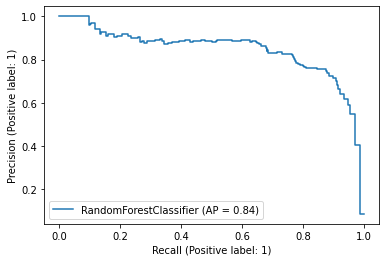

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(16,10))

disp = plot_precision_recall_curve(clf, test_feature_df, test_true_y)